In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets
# 모델 요약
from torchvision import models, utils
from torchsummary import summary

import time

In [2]:
## 네트워크를 저장하거나 불러오는 함수 작성하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               '%s/model_epoch%d.pth' % (ckpt_dir, epoch))

def load(ckpt_dir, net, optim):
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])

    return net, optim

In [3]:
# 학습률, batch, epoch
lr = 1e-3
batch_size = 64
num_epoch = 10

# 학습된 network가 저장될 디렉터리
ckpt_dir = 'D:/torchtorch/checkpoint9'
# 텐서보드 파일이 저장될 디렉터리
log_dir = 'D:/torchtorch/log9'
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 기존 ImageNet 학습한 resnet18 모델 불러오기 
Model_RESNET18 = models.resnet18(pretrained=True)
# ResNet fc layer의 in_features
Num_Features = Model_RESNET18.fc.in_features
# 10개의 클래스만 분류하면 되므로 마지막 fc layer만 변경(fine tuning)
Model_RESNET18.fc = nn.Linear(Num_Features, 10).cuda()
# GPU 할당
Model_RESNET18 = Model_RESNET18.to(device)

In [5]:
Model_RESNET18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
for name, param in Model_RESNET18.named_parameters():
    if param.requires_grad == True:
        print (name, param.data)

conv1.weight tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01],
       

layer1.1.conv1.weight tensor([[[[ 1.9712e-02, -5.2562e-03, -3.7619e-03],
          [-1.9635e-02, -1.2336e-02, -3.5196e-02],
          [ 5.0761e-02,  7.5668e-02,  4.3344e-02]],

         [[ 1.4160e-02, -8.6094e-03, -1.0541e-02],
          [-4.2586e-02, -2.3814e-02, -5.4694e-02],
          [-1.4018e-03,  4.6720e-02,  5.0898e-02]],

         [[ 2.1559e-02,  4.1633e-03, -9.7118e-03],
          [-9.3201e-03, -2.5432e-02, -2.8274e-02],
          [-3.0107e-02, -4.8230e-02, -2.6001e-02]],

         ...,

         [[ 5.4300e-03,  9.1875e-02,  3.1938e-03],
          [-1.7945e-02,  5.7266e-02, -8.4098e-03],
          [-3.4961e-02, -2.3296e-02, -3.5089e-02]],

         [[ 2.5603e-02, -3.1689e-02, -5.4160e-02],
          [ 6.9736e-02, -1.0716e-02, -6.8034e-02],
          [ 3.5578e-02,  3.4749e-02, -1.9334e-02]],

         [[-6.5420e-02, -4.6427e-03, -2.3362e-02],
          [ 7.5833e-02,  9.1174e-03, -4.9701e-02],
          [ 6.2944e-02, -9.8735e-02,  3.3158e-02]]],


        [[[-9.0557e-03, -3.0753

       device='cuda:0')
layer2.1.conv1.weight tensor([[[[-9.9023e-04, -7.7429e-03, -7.9740e-03],
          [ 2.4844e-02,  1.8642e-03,  5.8352e-03],
          [ 9.5089e-03, -1.6476e-02,  3.9157e-03]],

         [[-2.1488e-02, -1.2330e-03, -1.4281e-02],
          [-1.7044e-02,  9.5922e-03,  7.0445e-03],
          [ 1.0790e-02, -7.2350e-03, -1.1357e-02]],

         [[-1.1126e-03,  3.0388e-02,  2.2247e-02],
          [-6.1184e-02, -2.3797e-02,  2.3747e-03],
          [ 4.0678e-02, -1.0356e-01, -6.0011e-02]],

         ...,

         [[-8.5833e-03,  1.1438e-02,  2.0800e-02],
          [-1.6565e-02, -3.9587e-02,  1.2594e-02],
          [-1.4314e-03, -5.4257e-03,  3.6794e-02]],

         [[-1.3687e-02, -2.9514e-02, -1.4745e-02],
          [ 2.8299e-02,  2.2096e-02,  3.4839e-03],
          [-4.3521e-03, -2.6706e-03,  1.2258e-04]],

         [[ 7.6403e-03,  2.0666e-02,  3.7429e-02],
          [ 6.9478e-03,  4.3983e-02,  1.7538e-02],
          [-9.7797e-03, -2.4789e-02, -1.1349e-03]]],


       

layer3.0.conv2.weight tensor([[[[-0.0093, -0.0339, -0.0119],
          [-0.0246, -0.0798, -0.0487],
          [-0.0435, -0.0801, -0.0653]],

         [[-0.0289,  0.0002, -0.0286],
          [ 0.0099,  0.0103, -0.0177],
          [-0.0107,  0.0028, -0.0125]],

         [[-0.0147,  0.0226,  0.0044],
          [ 0.0155,  0.0109, -0.0040],
          [-0.0208, -0.0180, -0.0173]],

         ...,

         [[ 0.0003, -0.0041, -0.0008],
          [-0.0217, -0.0223, -0.0299],
          [ 0.0105,  0.0035, -0.0114]],

         [[ 0.0097,  0.0184,  0.0370],
          [ 0.0037,  0.0104,  0.0152],
          [ 0.0084,  0.0183,  0.0302]],

         [[ 0.0014,  0.0084,  0.0097],
          [ 0.0265,  0.0415,  0.0553],
          [ 0.0169,  0.0610,  0.0563]]],


        [[[ 0.0117,  0.0165,  0.0051],
          [ 0.0294,  0.0204,  0.0216],
          [ 0.0079,  0.0133,  0.0117]],

         [[-0.0153, -0.0213, -0.0090],
          [-0.0292, -0.0516, -0.0436],
          [-0.0045, -0.0372, -0.0420]],

         

        0.3634, 0.2615, 0.1999, 0.2541], device='cuda:0')
layer3.1.bn2.bias tensor([-0.0162, -0.2033,  0.0294, -0.1697, -0.1840, -0.0309, -0.2039, -0.1426,
        -0.0443, -0.0886, -0.0647, -0.0968, -0.0380, -0.2073, -0.3061,  0.1443,
        -0.3079, -0.1232, -0.1627, -0.0980, -0.2471, -0.2837, -0.1201, -0.2893,
        -0.2303, -0.3562, -0.0825, -0.3483,  0.0707, -0.1321, -0.1074, -0.1451,
         0.0235,  0.0225, -0.1885, -0.2507, -0.2461,  0.0631, -0.0023, -0.1209,
        -0.2581, -0.1640, -0.0172, -0.1143, -0.2096, -0.0158,  0.0128, -0.1332,
        -0.3139, -0.2294, -0.1527, -0.3503,  0.2086,  0.0785, -0.1597, -0.1990,
         0.0346,  0.0388, -0.1269,  0.1019,  0.0981, -0.0390, -0.2537, -0.1356,
        -0.1796, -0.2422, -0.4517, -0.3124, -0.0177, -0.2615, -0.1567,  0.0212,
        -0.0753, -0.1426, -0.2788,  0.0062, -0.1895, -0.2327, -0.1298, -0.1200,
        -0.1917, -0.0987, -0.1916, -0.1666, -0.2729,  0.1287, -0.4620, -0.2259,
        -0.2270,  0.1939,  0.0230, -0.3303, 

       device='cuda:0')
layer4.0.bn2.bias tensor([-0.1759, -0.2156, -0.2047, -0.1695, -0.1628, -0.1473, -0.2158, -0.2905,
        -0.1112, -0.2196, -0.1020, -0.1549, -0.1989, -0.0445, -0.1508, -0.1920,
        -0.2114, -0.1655, -0.1854, -0.1733, -0.1289, -0.2376, -0.1965, -0.1965,
        -0.1776, -0.1774, -0.1760, -0.1546, -0.1648, -0.2599, -0.1752, -0.2498,
        -0.1741, -0.2410, -0.2498, -0.2938, -0.1496, -0.1578, -0.1800, -0.1851,
        -0.1516, -0.1345, -0.2746, -0.1248, -0.2246, -0.2531, -0.2398, -0.1859,
        -0.1739, -0.2393, -0.1214, -0.1803, -0.2729, -0.2617, -0.1855, -0.2316,
        -0.2333, -0.1860, -0.2097, -0.0692, -0.1912, -0.2078, -0.1084, -0.2810,
        -0.1303, -0.1654, -0.2119, -0.3641, -0.2951, -0.2384, -0.1632, -0.1892,
        -0.1792, -0.2031, -0.1770, -0.2738, -0.3324, -0.1725, -0.1793, -0.2638,
        -0.2207, -0.1609, -0.1534, -0.1414, -0.2992, -0.1450, -0.1838, -0.1779,
        -0.1422, -0.2198, -0.1900, -0.1580, -0.1666, -0.2490, -0.1569, -0.1718

layer4.1.bn1.bias tensor([-0.1668, -0.3019, -0.2187, -0.2917, -0.1971, -0.2325, -0.1869, -0.1857,
        -0.2474, -0.1629, -0.2448, -0.2508, -0.1895, -0.2651, -0.3250, -0.3811,
        -0.2953, -0.4963, -0.0294, -0.2724, -0.2007, -0.2220, -0.2945, -0.2579,
        -0.5152, -0.1994, -0.5016, -0.2736, -0.4528, -0.3968, -0.2281, -0.1772,
        -0.1293, -0.2655, -0.3252, -0.3232, -0.3337, -0.1901, -0.0692, -0.2196,
        -0.2132, -0.2565, -0.1646, -0.1567, -0.2087, -0.2178, -0.2480, -0.2767,
        -0.3071, -0.1988, -0.1985, -0.0235, -0.2458, -0.4156, -0.1660, -0.1923,
        -0.3328, -0.1481, -0.3047, -0.2277, -0.3182, -0.2744, -0.1643, -0.3365,
        -0.4050, -0.2082, -0.0621, -0.2671, -0.2809, -0.2185, -0.2148, -0.4465,
        -0.3376, -0.3213, -0.2921, -0.1998, -0.3369, -0.2092, -0.2831, -0.2893,
        -0.1719, -0.2189, -0.4016, -0.2484, -0.2070, -0.3849, -0.3753, -0.5874,
        -0.1637, -0.1748, -0.2217, -0.5067, -0.2496, -0.2117, -0.4291, -0.1944,
        -0.3089, -0.26

In [7]:
## 모델 요약
print(summary(Model_RESNET18, (3,244,244)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [8]:
from torch.optim import lr_scheduler
## 필요한 손실함수 구현하기

fn_loss = nn.CrossEntropyLoss().to(device)
fn_pred = lambda output: torch.softmax(output, dim=1)
fn_acc = lambda pred, label: ((pred.max(dim=1)[1] == label).type(torch.float)).mean()

optim = torch.optim.Adam(Model_RESNET18.parameters(), lr=lr)

# 이전 learning rate 변경폭에 따라 학습률 재조정 시켜줌
# !! Train에서만 사용함
# mode='max': accuracy, 'min' : loss 탐색
scheduler = lr_scheduler.ReduceLROnPlateau(optim, patience=5, mode='min', factor = 0.5, verbose=1, threshold=0.003)

## early stopping condition 정의
n_epochs_stop = 10
epochs_no_improve = 0
early_stop = False
min_val_loss = np.Inf

writer = SummaryWriter(log_dir=log_dir)

In [9]:
## CIFAR10 데이터 불러오기
## 이미지 전처리 과정
# 1. 이미지 텐서 변환 및 정규화 등 수행(.Compose) 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,)),
                                # 이미지 resize, resize하면서 생기는 pixel은 BILINEAR interpolation 수행
                                transforms.Resize(224, interpolation=2)])

# 2. 데이터셋 불러오기
dataset = datasets.CIFAR10(download=True, root='./.data/', train=True, transform=transform)

# 3. 데이터셋 나누기
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# 4. 1배치에 들어갈 데이터 
# 1epoch = 50000개 = 64batch
# 1batch = 50000/64(batch_size) = 938
num_data = len(loader.dataset)
num_batch = np.ceil(num_data / batch_size)

Files already downloaded and verified


In [10]:
print(num_data)
print(num_batch)

50000
782.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
torch.Size([64])
tensor([2, 0, 2, 6, 1, 8, 4, 5, 4, 2, 6, 7, 0, 3, 5, 3, 0, 2, 3, 3, 2, 0, 6, 3,
        2, 8, 8, 6, 0, 9, 0, 9, 6, 9, 9, 5, 0, 4, 7, 8, 6, 8, 9, 0, 7, 2, 7, 1,
        5, 1, 0, 5, 7, 4, 8, 9, 4, 6, 5, 8, 6, 9, 7, 1])


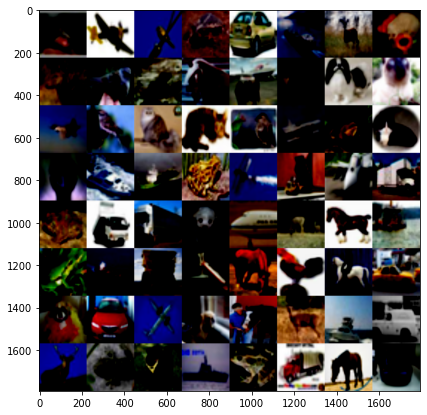

In [11]:
## 데이터셋 시각화하기
# 배치 1개의 image와 label 들을 확인해보기(64개 이미지 존재)
dataiter = iter(loader)
images, labels = next(dataiter)
# 시각화 하기
img = utils.make_grid(images, padding=0)
# 원래 이미지 -> 64개(1epoch, channel, height, width)
print(images.shape)
print(labels.shape)
print(labels)
npimg = img.numpy()
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [12]:
# 클래스 딕셔너리로 만들기
CLASSES = {
    0 : 'plane',
    1 : 'car',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}
# labels 는 0부터 9까지의 숫자로 이루어져 있다.
# 이를 CLASSES에 있는 index와 일치시킨다.
# print(labels)
# for label in labels :
#     index = label.item()
#     print(CLASSES[index])

In [13]:
## 트레이닝 시작하기
st_epoch = 0
# train 시작시간 
st_time = time.time()
 
for epoch in range(st_epoch + 1, num_epoch + 1):
    Model_RESNET18.train()
    
    ## early stopping condition 각 epoch마다 초기화해주기
    epochs_no_improve = 0
    early_stop = False
    min_val_loss = np.Inf
    
    loss_arr = []
    acc_arr = []

    for  batch, (input, label) in enumerate(loader, 1):
        
        input = input.to(device)
        # input shape = (batch, channel, height, width)
#         print(input.shape)
        
        label = label.to(device)
        # label shape = (batch)
#         print(label.shape)
        
        output = Model_RESNET18(input)
        # output shape = (batch, 10)
#         print(output.shape)
        
        # pred shape = (batch, 10)
        pred = fn_pred(output)
#         print(pred.shape)
        
        # 모든 model parameter의 gradient를 0으로 설정한다.(epoch마다 새롭게, loss 증가 방지)
        optim.zero_grad()

        # loss와 acc를 계산
        loss = fn_loss(output, label)
        acc = fn_acc(pred, label)
    
        # loss와 chain rule를 통해 각 layer의 gradient를 계산한다.
        loss.backward()
        
        # parameter를 update한다.
        optim.step()

        loss_arr += [loss.item()]
        acc_arr += [acc.item()]

        print('TRAIN: EPOCH %04d/%04d | BATCH %04d/%04d | LOSS: %.4f | ACC %.4f' %
              (epoch, num_epoch, batch, num_batch, np.mean(loss_arr), np.mean(acc_arr)))
        
        # scheduler.step(np.mean(loss_arr))
        
        # loss가 향상되지 않았다면 count를 증가시킨다.
        if np.mean(loss_arr) < min_val_loss :
            epochs_no_improve = 0
            min_val_loss = np.mean(loss_arr)
        else :
            epochs_no_improve += 1
        # 만약 향상되지 않은 count가 지정한 횟수에 도달하면 빠져나간다.
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!' )
            early_stop = True
            print("Stopped")
            break
        else:
            continue
    
    writer.add_scalar('loss', np.mean(loss_arr), epoch)
    writer.add_scalar('acc', np.mean(acc_arr), epoch)
    
    save(ckpt_dir = ckpt_dir, net=Model_RESNET18, optim=optim, epoch=epoch)
    
# train 종료 시간 
time_elapsed = time.time() - st_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
writer.close()

TRAIN: EPOCH 0001/0010 | BATCH 0001/0782 | LOSS: 2.3403 | ACC 0.1406
TRAIN: EPOCH 0001/0010 | BATCH 0002/0782 | LOSS: 1.9132 | ACC 0.3438
TRAIN: EPOCH 0001/0010 | BATCH 0003/0782 | LOSS: 1.7097 | ACC 0.4219
TRAIN: EPOCH 0001/0010 | BATCH 0004/0782 | LOSS: 1.6532 | ACC 0.4531
TRAIN: EPOCH 0001/0010 | BATCH 0005/0782 | LOSS: 1.6370 | ACC 0.4594
TRAIN: EPOCH 0001/0010 | BATCH 0006/0782 | LOSS: 1.5993 | ACC 0.4635
TRAIN: EPOCH 0001/0010 | BATCH 0007/0782 | LOSS: 1.5370 | ACC 0.4821
TRAIN: EPOCH 0001/0010 | BATCH 0008/0782 | LOSS: 1.5039 | ACC 0.4961
TRAIN: EPOCH 0001/0010 | BATCH 0009/0782 | LOSS: 1.4587 | ACC 0.5122
TRAIN: EPOCH 0001/0010 | BATCH 0010/0782 | LOSS: 1.3986 | ACC 0.5375
TRAIN: EPOCH 0001/0010 | BATCH 0011/0782 | LOSS: 1.3506 | ACC 0.5497
TRAIN: EPOCH 0001/0010 | BATCH 0012/0782 | LOSS: 1.3576 | ACC 0.5469
TRAIN: EPOCH 0001/0010 | BATCH 0013/0782 | LOSS: 1.3502 | ACC 0.5553
TRAIN: EPOCH 0001/0010 | BATCH 0014/0782 | LOSS: 1.3355 | ACC 0.5569
TRAIN: EPOCH 0001/0010 | BATCH 001

TRAIN: EPOCH 0001/0010 | BATCH 0120/0782 | LOSS: 0.8735 | ACC 0.7053
TRAIN: EPOCH 0001/0010 | BATCH 0121/0782 | LOSS: 0.8715 | ACC 0.7057
TRAIN: EPOCH 0001/0010 | BATCH 0122/0782 | LOSS: 0.8688 | ACC 0.7067
TRAIN: EPOCH 0001/0010 | BATCH 0123/0782 | LOSS: 0.8691 | ACC 0.7066
TRAIN: EPOCH 0001/0010 | BATCH 0124/0782 | LOSS: 0.8687 | ACC 0.7065
TRAIN: EPOCH 0001/0010 | BATCH 0125/0782 | LOSS: 0.8677 | ACC 0.7067
TRAIN: EPOCH 0001/0010 | BATCH 0126/0782 | LOSS: 0.8669 | ACC 0.7068
TRAIN: EPOCH 0001/0010 | BATCH 0127/0782 | LOSS: 0.8640 | ACC 0.7080
TRAIN: EPOCH 0001/0010 | BATCH 0128/0782 | LOSS: 0.8637 | ACC 0.7083
TRAIN: EPOCH 0001/0010 | BATCH 0129/0782 | LOSS: 0.8619 | ACC 0.7091
TRAIN: EPOCH 0001/0010 | BATCH 0130/0782 | LOSS: 0.8592 | ACC 0.7101
TRAIN: EPOCH 0001/0010 | BATCH 0131/0782 | LOSS: 0.8569 | ACC 0.7111
TRAIN: EPOCH 0001/0010 | BATCH 0132/0782 | LOSS: 0.8541 | ACC 0.7122
TRAIN: EPOCH 0001/0010 | BATCH 0133/0782 | LOSS: 0.8536 | ACC 0.7126
TRAIN: EPOCH 0001/0010 | BATCH 013

TRAIN: EPOCH 0001/0010 | BATCH 0239/0782 | LOSS: 0.7509 | ACC 0.7475
TRAIN: EPOCH 0001/0010 | BATCH 0240/0782 | LOSS: 0.7497 | ACC 0.7477
TRAIN: EPOCH 0001/0010 | BATCH 0241/0782 | LOSS: 0.7489 | ACC 0.7481
TRAIN: EPOCH 0001/0010 | BATCH 0242/0782 | LOSS: 0.7480 | ACC 0.7484
TRAIN: EPOCH 0001/0010 | BATCH 0243/0782 | LOSS: 0.7466 | ACC 0.7489
TRAIN: EPOCH 0001/0010 | BATCH 0244/0782 | LOSS: 0.7455 | ACC 0.7491
TRAIN: EPOCH 0001/0010 | BATCH 0245/0782 | LOSS: 0.7445 | ACC 0.7496
TRAIN: EPOCH 0001/0010 | BATCH 0246/0782 | LOSS: 0.7435 | ACC 0.7499
TRAIN: EPOCH 0001/0010 | BATCH 0247/0782 | LOSS: 0.7429 | ACC 0.7504
TRAIN: EPOCH 0001/0010 | BATCH 0248/0782 | LOSS: 0.7419 | ACC 0.7506
TRAIN: EPOCH 0001/0010 | BATCH 0249/0782 | LOSS: 0.7420 | ACC 0.7504
TRAIN: EPOCH 0001/0010 | BATCH 0250/0782 | LOSS: 0.7413 | ACC 0.7506
TRAIN: EPOCH 0001/0010 | BATCH 0251/0782 | LOSS: 0.7404 | ACC 0.7506
TRAIN: EPOCH 0001/0010 | BATCH 0252/0782 | LOSS: 0.7396 | ACC 0.7509
TRAIN: EPOCH 0001/0010 | BATCH 025

TRAIN: EPOCH 0001/0010 | BATCH 0358/0782 | LOSS: 0.6765 | ACC 0.7713
TRAIN: EPOCH 0001/0010 | BATCH 0359/0782 | LOSS: 0.6756 | ACC 0.7715
TRAIN: EPOCH 0001/0010 | BATCH 0360/0782 | LOSS: 0.6751 | ACC 0.7717
TRAIN: EPOCH 0001/0010 | BATCH 0361/0782 | LOSS: 0.6752 | ACC 0.7716
TRAIN: EPOCH 0001/0010 | BATCH 0362/0782 | LOSS: 0.6744 | ACC 0.7720
TRAIN: EPOCH 0001/0010 | BATCH 0363/0782 | LOSS: 0.6740 | ACC 0.7720
TRAIN: EPOCH 0001/0010 | BATCH 0364/0782 | LOSS: 0.6739 | ACC 0.7719
TRAIN: EPOCH 0001/0010 | BATCH 0365/0782 | LOSS: 0.6734 | ACC 0.7721
TRAIN: EPOCH 0001/0010 | BATCH 0366/0782 | LOSS: 0.6732 | ACC 0.7721
TRAIN: EPOCH 0001/0010 | BATCH 0367/0782 | LOSS: 0.6727 | ACC 0.7722
TRAIN: EPOCH 0001/0010 | BATCH 0368/0782 | LOSS: 0.6721 | ACC 0.7723
TRAIN: EPOCH 0001/0010 | BATCH 0369/0782 | LOSS: 0.6729 | ACC 0.7720
TRAIN: EPOCH 0001/0010 | BATCH 0370/0782 | LOSS: 0.6726 | ACC 0.7723
TRAIN: EPOCH 0001/0010 | BATCH 0371/0782 | LOSS: 0.6726 | ACC 0.7723
TRAIN: EPOCH 0001/0010 | BATCH 037

TRAIN: EPOCH 0001/0010 | BATCH 0477/0782 | LOSS: 0.6331 | ACC 0.7850
TRAIN: EPOCH 0001/0010 | BATCH 0478/0782 | LOSS: 0.6327 | ACC 0.7852
TRAIN: EPOCH 0001/0010 | BATCH 0479/0782 | LOSS: 0.6323 | ACC 0.7854
TRAIN: EPOCH 0001/0010 | BATCH 0480/0782 | LOSS: 0.6319 | ACC 0.7856
TRAIN: EPOCH 0001/0010 | BATCH 0481/0782 | LOSS: 0.6318 | ACC 0.7855
TRAIN: EPOCH 0001/0010 | BATCH 0482/0782 | LOSS: 0.6313 | ACC 0.7857
TRAIN: EPOCH 0001/0010 | BATCH 0483/0782 | LOSS: 0.6314 | ACC 0.7857
TRAIN: EPOCH 0001/0010 | BATCH 0484/0782 | LOSS: 0.6314 | ACC 0.7856
TRAIN: EPOCH 0001/0010 | BATCH 0485/0782 | LOSS: 0.6313 | ACC 0.7857
TRAIN: EPOCH 0001/0010 | BATCH 0486/0782 | LOSS: 0.6313 | ACC 0.7858
TRAIN: EPOCH 0001/0010 | BATCH 0487/0782 | LOSS: 0.6310 | ACC 0.7858
TRAIN: EPOCH 0001/0010 | BATCH 0488/0782 | LOSS: 0.6310 | ACC 0.7860
TRAIN: EPOCH 0001/0010 | BATCH 0489/0782 | LOSS: 0.6314 | ACC 0.7859
TRAIN: EPOCH 0001/0010 | BATCH 0490/0782 | LOSS: 0.6313 | ACC 0.7859
TRAIN: EPOCH 0001/0010 | BATCH 049

TRAIN: EPOCH 0001/0010 | BATCH 0596/0782 | LOSS: 0.5964 | ACC 0.7978
TRAIN: EPOCH 0001/0010 | BATCH 0597/0782 | LOSS: 0.5962 | ACC 0.7978
TRAIN: EPOCH 0001/0010 | BATCH 0598/0782 | LOSS: 0.5960 | ACC 0.7979
TRAIN: EPOCH 0001/0010 | BATCH 0599/0782 | LOSS: 0.5956 | ACC 0.7981
TRAIN: EPOCH 0001/0010 | BATCH 0600/0782 | LOSS: 0.5954 | ACC 0.7982
TRAIN: EPOCH 0001/0010 | BATCH 0601/0782 | LOSS: 0.5951 | ACC 0.7984
TRAIN: EPOCH 0001/0010 | BATCH 0602/0782 | LOSS: 0.5948 | ACC 0.7985
TRAIN: EPOCH 0001/0010 | BATCH 0603/0782 | LOSS: 0.5951 | ACC 0.7985
TRAIN: EPOCH 0001/0010 | BATCH 0604/0782 | LOSS: 0.5947 | ACC 0.7986
TRAIN: EPOCH 0001/0010 | BATCH 0605/0782 | LOSS: 0.5945 | ACC 0.7986
TRAIN: EPOCH 0001/0010 | BATCH 0606/0782 | LOSS: 0.5940 | ACC 0.7988
TRAIN: EPOCH 0001/0010 | BATCH 0607/0782 | LOSS: 0.5936 | ACC 0.7989
TRAIN: EPOCH 0001/0010 | BATCH 0608/0782 | LOSS: 0.5938 | ACC 0.7988
TRAIN: EPOCH 0001/0010 | BATCH 0609/0782 | LOSS: 0.5936 | ACC 0.7989
TRAIN: EPOCH 0001/0010 | BATCH 061

TRAIN: EPOCH 0001/0010 | BATCH 0715/0782 | LOSS: 0.5681 | ACC 0.8079
TRAIN: EPOCH 0001/0010 | BATCH 0716/0782 | LOSS: 0.5680 | ACC 0.8079
TRAIN: EPOCH 0001/0010 | BATCH 0717/0782 | LOSS: 0.5676 | ACC 0.8081
TRAIN: EPOCH 0001/0010 | BATCH 0718/0782 | LOSS: 0.5674 | ACC 0.8081
TRAIN: EPOCH 0001/0010 | BATCH 0719/0782 | LOSS: 0.5674 | ACC 0.8081
TRAIN: EPOCH 0001/0010 | BATCH 0720/0782 | LOSS: 0.5674 | ACC 0.8080
TRAIN: EPOCH 0001/0010 | BATCH 0721/0782 | LOSS: 0.5673 | ACC 0.8081
TRAIN: EPOCH 0001/0010 | BATCH 0722/0782 | LOSS: 0.5670 | ACC 0.8081
TRAIN: EPOCH 0001/0010 | BATCH 0723/0782 | LOSS: 0.5668 | ACC 0.8083
TRAIN: EPOCH 0001/0010 | BATCH 0724/0782 | LOSS: 0.5667 | ACC 0.8083
TRAIN: EPOCH 0001/0010 | BATCH 0725/0782 | LOSS: 0.5665 | ACC 0.8083
TRAIN: EPOCH 0001/0010 | BATCH 0726/0782 | LOSS: 0.5662 | ACC 0.8084
TRAIN: EPOCH 0001/0010 | BATCH 0727/0782 | LOSS: 0.5663 | ACC 0.8084
TRAIN: EPOCH 0001/0010 | BATCH 0728/0782 | LOSS: 0.5660 | ACC 0.8085
TRAIN: EPOCH 0001/0010 | BATCH 072

TRAIN: EPOCH 0005/0010 | BATCH 0001/0782 | LOSS: 0.2238 | ACC 0.9219
TRAIN: EPOCH 0005/0010 | BATCH 0002/0782 | LOSS: 0.2226 | ACC 0.9219
TRAIN: EPOCH 0005/0010 | BATCH 0003/0782 | LOSS: 0.2724 | ACC 0.9062
TRAIN: EPOCH 0005/0010 | BATCH 0004/0782 | LOSS: 0.2925 | ACC 0.8945
TRAIN: EPOCH 0005/0010 | BATCH 0005/0782 | LOSS: 0.2993 | ACC 0.8844
TRAIN: EPOCH 0005/0010 | BATCH 0006/0782 | LOSS: 0.3137 | ACC 0.8776
TRAIN: EPOCH 0005/0010 | BATCH 0007/0782 | LOSS: 0.3218 | ACC 0.8750
TRAIN: EPOCH 0005/0010 | BATCH 0008/0782 | LOSS: 0.3078 | ACC 0.8848
TRAIN: EPOCH 0005/0010 | BATCH 0009/0782 | LOSS: 0.3121 | ACC 0.8854
TRAIN: EPOCH 0005/0010 | BATCH 0010/0782 | LOSS: 0.3261 | ACC 0.8812
TRAIN: EPOCH 0005/0010 | BATCH 0011/0782 | LOSS: 0.3221 | ACC 0.8821
TRAIN: EPOCH 0005/0010 | BATCH 0012/0782 | LOSS: 0.3143 | ACC 0.8841
Early stopping!
Stopped
TRAIN: EPOCH 0006/0010 | BATCH 0001/0782 | LOSS: 0.1777 | ACC 0.9375
TRAIN: EPOCH 0006/0010 | BATCH 0002/0782 | LOSS: 0.1854 | ACC 0.9375
TRAIN: EPO